## Header import

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import seaborn as sns


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Data Read

In [2]:
# Input the data path
data_path = "data (2).csv"

# Store the data from csv to dataframe
alldata_df = pd.read_csv(data_path)
alldata_df

,timestamp,part_id,temperature_1,temperature_2,temperature_3,temperature_4,label
0,2024-02-15 05:44:34+05:30,2124077390649042,439.1,424.1,536.0,518.6,0
1,2024-02-15 05:44:35+05:30,2124077390649042,438.9,423.9,535.9,518.7,0
2,2024-02-15 05:44:36+05:30,2124077390649042,438.7,423.6,535.6,518.9,0
3,2024-02-15 05:44:37+05:30,2124077390649042,438.4,423.4,535.4,519.0,0
4,2024-02-15 05:44:38+05:30,2124077390649042,438.2,423.2,535.2,519.2,0
...,...,...,...,...,...,...,...
99995,2024-02-18 04:13:14+05:30,2124087523419042,479.6,460.8,571.1,532.7,0
99996,2024-02-18 04:13:15+05:30,2124087523419042,479.8,460.7,571.2,533.0,0
99997,2024-02-18 04:13:16+05:30,2124087523419042,480.2,460.6,571.2,533.2,0
99998,2024-02-18 04:13:17+05:30,2124087523419042,480.4,460.4,571.3,533.4,0


## Exploratary Data Analysis

### Check - Data Completeness / Missing Values

In [3]:
# Display basic information about the data
print("Dataset Info:")
print(alldata_df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   timestamp      100000 non-null  object 
 1   part_id        100000 non-null  int64  
 2   temperature_1  100000 non-null  float64
 3   temperature_2  100000 non-null  float64
 4   temperature_3  100000 non-null  float64
 5   temperature_4  100000 non-null  float64
 6   label          100000 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 5.3+ MB
None


### Observations

#### Data Shape:

The dataset has 100,000 rows and 7 columns, indicating it is relatively large but manageable in memory for standard data processing.

#### Data Completeness:

There are no missing values in any of the columns, as the **non-null** count is equal to the total number of entries (100,000) for each column. This is excellent as no imputation or data cleaning is needed for missing data.

#### Data Types:

- **timestamp:** Object (string) data type. This will need to be converted to a datetime type for proper time-series processing.
- **part_id:** Integer type. This column serves as an identifier for different parts and will not be used as a feature directly.
- **temperature_1 to temperature_4:** Float type. These are the continuous numerical variables that will be analyzed and used for feature engineering.
- **label:** Integer type. This is the target variable indicating part quality (binary: 0 = good, 1 = bad).

#### Memory Usage:

The dataset occupies approximately 5.3 MB, which is efficient for in-memory operations using Python's pandas library.

In [4]:
# This is another way to verify for missing values
if alldata_df.isnull().values.any():
    print("There are null values in the dataset.")
else:
    print("No null values in the dataset.")

No null values in the dataset.


### Check - Outliers

In [5]:
# Basic statistics of numerical columns
print("\nBasic Statistics:")
print(alldata_df.describe())


Basic Statistics:
            part_id  temperature_1  temperature_2  temperature_3  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   2.124078e+15     455.534524     440.114258     546.868253   
std    2.901028e+09      20.596332      23.310541      24.818341   
min    2.124077e+15     350.800000     329.600000     407.700000   
25%    2.124077e+15     440.600000     425.200000     532.600000   
50%    2.124077e+15     454.000000     441.300000     550.000000   
75%    2.124077e+15     472.600000     459.500000     567.200000   
max    2.124088e+15     501.200000     481.000000     582.700000   

       temperature_4          label  
count  100000.000000  100000.000000  
mean      517.654658       0.059700  
std        17.513545       0.236931  
min       435.600000       0.000000  
25%       508.500000       0.000000  
50%       518.300000       0.000000  
75%       530.200000       0.000000  
max       555.400000       1.000000  


### Observations

#### Temperature Columns:

The temperature columns (temperature_1, temperature_2, temperature_3, temperature_4) have reasonable means and standard deviations.

The values for all sensors seem to range within expected limits for machine temperatures:

 - **temperature_1:** 350.8 to 501.2 (mean: ~455.5, std: ~20.6)
 - **temperature_2:** 329.6 to 481.0 (mean: ~440.1, std: ~23.3)
 - **temperature_3:** 407.7 to 582.7 (mean: ~546.9, std: ~24.8)
 - **temperature_4:** 435.6 to 555.4 (mean: ~517.7, std: ~17.5)
   
The ranges seem consistent with minimal chance of outliers, as the max and min values are not excessively far from the mean ± 3 * std. Yet we can confirm by plotting the distribution

#### Label Distribution:

The mean of the label column is 0.0597, indicating that around 6% of the parts are labeled as bad (1). This shows **class imbalance** 





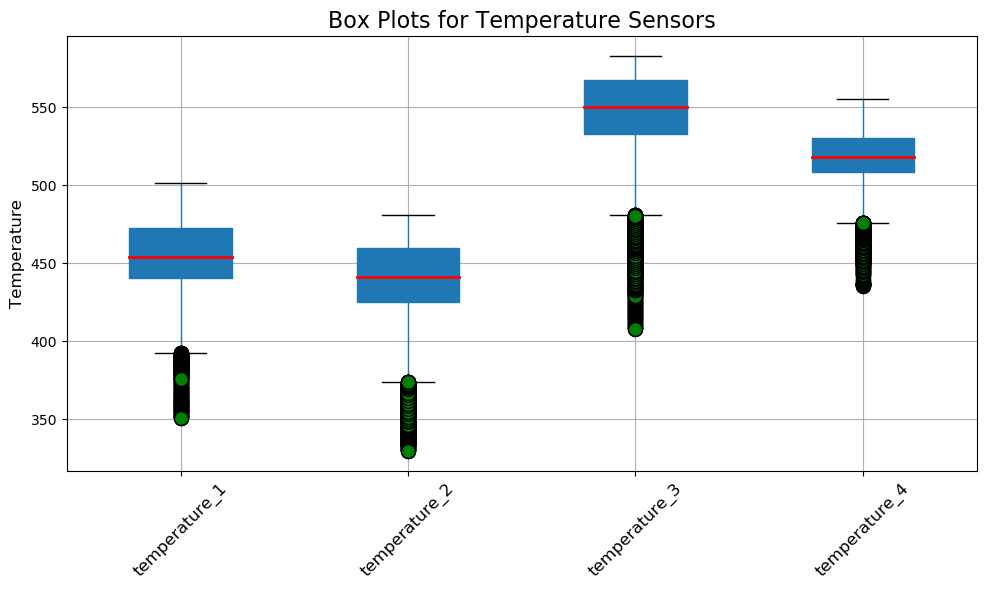

In [6]:
# List the data column for plot
temperature_columns = ['temperature_1', 'temperature_2', 'temperature_3', 'temperature_4']

# Plotting box plots to visualize outliers
plt.figure(figsize=(10, 6))

# Create a box plot for each temperature column
alldata_df[temperature_columns].boxplot(grid=True, vert=True, patch_artist=True, 
                                  medianprops={'color' : 'red', 'linewidth': 2}, 
                                  flierprops={'marker': 'o', 'markerfacecolor': 'g', 'markersize': 10})

# Title and labels
plt.title("Box Plots for Temperature Sensors", fontsize=16)
plt.ylabel('Temperature', fontsize=12)
plt.xticks([1, 2, 3, 4], temperature_columns, rotation=45, fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

### Observations:

**Outliers Below the Box:** These are data points significantly lower than the lower bound of the "whisker," indicated by the green dots. The fact that there are no upper outliers suggests the data does not have unusually high-temperature values compared to the spread of the central range. 

**Negative Skewness:** The presence of lower outliers could indicate the data distribution is left-skewed, meaning the left tail is longer.


In [7]:
# Identify outliers below the lower bound using Interquartile range
outliers_summary = {}
for col in temperature_columns:
    Q1 = alldata_df[col].quantile(0.25)
    Q3 = alldata_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    
    # Find outliers below the lower bound
    outliers = alldata_df[alldata_df[col] < lower_bound]
    outliers_summary[col] = len(outliers)

# Display the number of outliers for each column
print("Number of outliers below the lower bound for each temperature column:")
print(outliers_summary)

# Check the skewness of each column
print("\nSkewness of each temperature column:")
print(alldata_df[temperature_columns].skew())


Number of outliers below the lower bound for each temperature column:
{'temperature_1': 503, 'temperature_2': 978, 'temperature_3': 1845, 'temperature_4': 2435}

Skewness of each temperature column:
temperature_1   -0.280931
temperature_2   -0.735597
temperature_3   -1.121385
temperature_4   -0.677178
dtype: float64


### Observations:

#### Outliers Count:

- temperature_1: 503 outliers (least affected).
- temperature_4: 2435 outliers (most affected).
  
The increasing trend in outliers from temperature_1 to temperature_4 may indicate these sensors are more sensitive to production conditions or prone to anomalies.

#### Skewness:

All temperature columns have negative skewness, with temperature_3 (-1.121), temperature_2 (-0.735), and temperature_4 (-0.677) showing stronger skewness. This confirms that the data has longer tails on the lower end, leading to more extreme values.

### Check - Class imbalance 

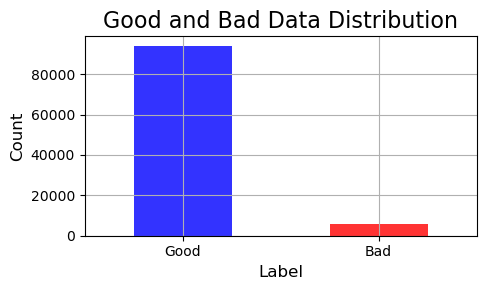

In [8]:
# Visualizing the label distribution
plt.figure(figsize=(5, 3))
alldata_df['label'].value_counts().sort_index().plot(
    kind='bar', color=["blue", "red"], alpha=0.8
)

# Adding title and labels
plt.title('Good and Bad Data Distribution', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(np.arange(2), ('Good', 'Bad'), rotation=0)

# Show the plot
plt.tight_layout()
plt.grid()
plt.show()

### Observation

The above chart gives an immediate visual impression of the data's imbalance.

#### Solution
- Will do SMOTE (Synthetic Minority Over-sampling Technique) before fitting the model to the training data
- Accuracy is not the best metric to evaluate, the F1-score will provide a better evaluation
- Will perform 5-fold cross-validation 

In [9]:
outlier_removed_df = alldata_df[(alldata_df[temperature_columns].apply(zscore).abs() < 3).all(axis=1)]

The outlier removal process is performed using the Z-score method, and the identified outliers are stored separately. This allows for a comparative analysis to assess whether removing the outliers significantly improves the model's performance in this scenario.

## Feature Engineering and Windowing

In [10]:
# Function to extract feature along with windowing
def feature_extraction(df):

    """
        Extracts windowed features from a dataframe grouped by a unique identifier (e.g., `part_id`). 
        The function creates overlapping windows of a specified size and calculates statistical features 
        (max, min, std) for temperature sensors within each window. 
        
        Additionally, it includes the start and end timestamps for each window and associates the label 
        of the last entry in the window as the output label.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe containing sensor data and labels. The dataframe is expected to have the 
            following columns:
            - 'part_id' (identifier for grouping)
            - 'timestamp' (time ordering column)
            - 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4' (sensor readings)
            - 'label' (target variable)
        
        Returns:
        --------
        tuple
            A tuple containing:
            - pandas.DataFrame: A dataframe with extracted features for each window.
            - pandas.Series: A series containing the labels corresponding to each window.
        """

    grouped = df.groupby('part_id')
    
    # Define window size (you can adjust 'k' as needed)
    window_size = 5  # I have taken 5 in this case
    
    # List to hold feature data for each window
    window_features = []
    
    # Loop through each group (each part_id)
    for part_id, group in grouped:
        # Ensure the data is sorted by timestamp or any other appropriate order
        group = group.sort_values('timestamp')
        
        # Create windows of consecutive parts
        for i in range(len(group) - window_size + 1):
            window = group.iloc[i:i + window_size]  # Select window of k parts
            
            # Calculate max, min, std for each temperature sensor within the window
            column_data = {
                'part_id': part_id,
                'window_start': window.iloc[0]['timestamp'],
                'window_end': window.iloc[-1]['timestamp'],
                'temperature_1_max': window['temperature_1'].max(),
                'temperature_1_min': window['temperature_1'].min(),
                'temperature_1_std': window['temperature_1'].std(),
                'temperature_2_max': window['temperature_2'].max(),
                'temperature_2_min': window['temperature_2'].min(),
                'temperature_2_std': window['temperature_2'].std(),
                'temperature_3_max': window['temperature_3'].max(),
                'temperature_3_min': window['temperature_3'].min(),
                'temperature_3_std': window['temperature_3'].std(),
                'temperature_4_max': window['temperature_4'].max(),
                'temperature_4_min': window['temperature_4'].min(),
                'temperature_4_std': window['temperature_4'].std(),
                'label': window.iloc[-1]['label']  # Label for the kth part (last part in window)
            }
            
            # Append calculated features for this window
            window_features.append(column_data)
        
    # Create new dataframe from the window features
    window_df = pd.DataFrame(window_features)
    
    # Display the new dataframe (each row corresponds to a window of consecutive parts)
    return window_df.drop(['label'], axis=1), window_df['label']


## Model

In [11]:
def fit_model(model, X_train, X_test, y_train, y_test, smote):

    """
        Trains a machine learning model, optionally applying SMOTE for class imbalance, 
        and evaluates its performance using accuracy and F1-score.
        
        Parameters:
        -----------
        model : sklearn.base.BaseEstimator
            The machine learning model to be trained (e.g., LogisticRegression, RandomForestClassifier, etc.).
            
        X_train : pandas.DataFrame or numpy.ndarray
            Training features.
            
        X_test : pandas.DataFrame or numpy.ndarray
            Testing features.
            
        y_train : pandas.Series or numpy.ndarray
            Training labels.
            
        y_test : pandas.Series or numpy.ndarray
            Testing labels.
            
        smote : bool
            Flag indicating whether to apply SMOTE (Synthetic Minority Oversampling Technique) 
            to handle class imbalance in the training data.
        
        Returns:
        --------
        tuple
            A tuple containing:
            - accuracy (float): Accuracy score of the model on the test data.
            - f1_score (float): F1-score of the model on the test data.
        """
    # Check if SMOTE should be applied for handling class imbalance
    if smote:
        smote = SMOTE(random_state=42)
         # Resample the training data to balance classes
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
    # Train the model on the (possibly resampled) training data    
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate and return performance metrics: accuracy and F1-score
    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

## Feature Extraction

In [12]:
features, label = feature_extraction(alldata_df)

## Feature Scaling

In [13]:
# Drop the columns except the features and label
features = features.drop(['part_id', 'window_start', 'window_end'], axis = 1)
feature_column = features.columns

# Scale the features using Min-Max scaler (0,1)
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

### Check for multicollinearity  or reduntant features

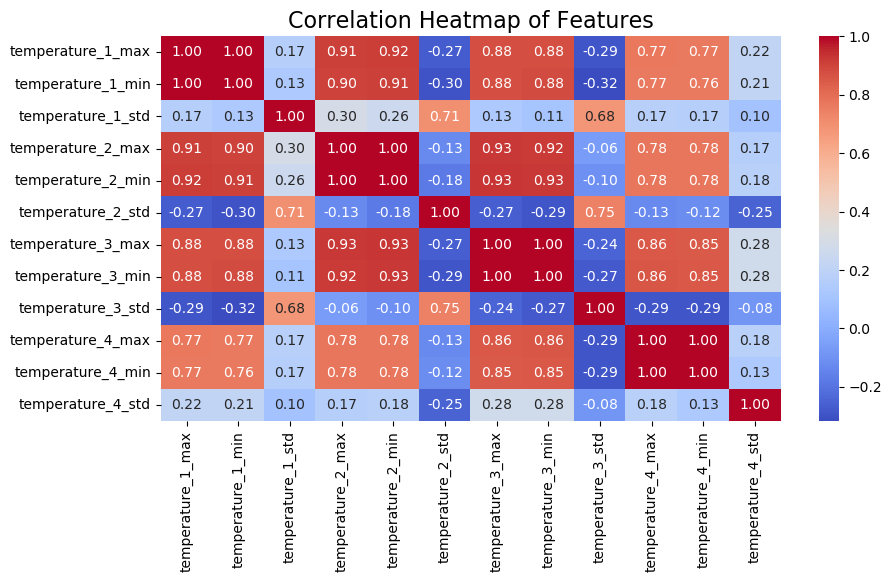

In [14]:
# Calculate correlation matrix
correlation_matrix = np.corrcoef(features, rowvar=False)
correlation_df = pd.DataFrame(correlation_matrix, index=feature_column, columns=feature_column)

# Plot heatmap using Seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()

### Observation

From the given correlation matrix

#### Strong Positive Correlations Within Same Sensor Groups
Each sensor's maximum and minimum temperatures are highly correlated with each other (e.g., temperature_1_max and temperature_1_min have a correlation of 0.999). This indicates that higher maximum temperatures are consistently accompanied by higher minimum temperatures within the same sensor.
Standard deviations within the same sensor groups (e.g., temperature_1_std) show relatively weaker correlations with their respective maximum and minimum values.

#### High Correlation Across Sensors
Max and min temperatures of different sensors are positively correlated. For instance:
temperature_1_max and temperature_2_max: 0.910
temperature_1_min and temperature_2_min: 0.916
This suggests that the temperature patterns across sensors are likely influenced by a common environmental factor.

### Moderate to Low Correlation of Standard Deviations
Standard deviations (std) show lower correlations with max and min temperatures. For example:
temperature_1_std and temperature_1_max: 0.169
temperature_1_std and temperature_1_min: 0.134
This indicates that the variability in temperatures is not strongly related to the absolute values of the temperatures.

#### Negative Correlations of Standard Deviations Across Sensors
Some std values show negative correlations with max and min temperatures of other sensors. For example:
temperature_2_std and temperature_1_max: -0.270
temperature_3_std and temperature_2_max: -0.265
This could indicate that higher variability in one sensor might correspond to more stable or lower temperatures in another.

#### Lower Correlation for Distant Sensors
Sensors further apart geographically or functionally (e.g., temperature_1 vs. temperature_4) tend to have weaker correlations than those closer in proximity or measurement context.

#### Insights for Time-Series Modeling
The high correlation of max and min temperatures across sensors suggests a potential multicollinearity issue if these variables are used together in a predictive model.
Standard deviations may provide additional information as they have distinct correlation patterns compared to max/min values.

#### Solution:
- Further Analysis: Should look for different features
- Should remove either of Max or Min feature and try

Since the features have been mentioned "min", "max" and "std" to use. I'm skeptical to neither remove nor add, one potential way to address this is PCA

In [15]:
# Apply PCA to retain 99% of the variance in the data
pca = PCA(0.99)
pca_features = pca.fit_transform(features)

##### PCA reduces the dimension as well as retains the most prominent patterns in the data

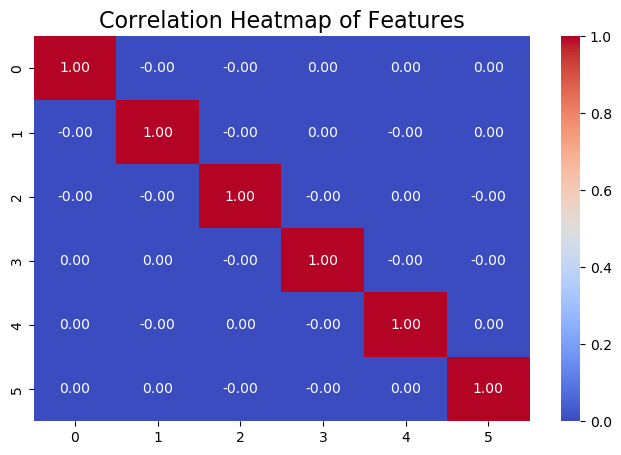

In [16]:
# Calculate correlation matrix
correlation_matrix = np.corrcoef(pca_features, rowvar=False)
correlation_df = pd.DataFrame(correlation_matrix)

# Plot heatmap using Seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()

Thus the above twelve features have been reduced to six features which can give better result

## Model Training and Evaluation

Its a good practice to start with a base model and build on it. So lets start with Logistic regression

### Logistic Regression

In [17]:
avg_acc = []
avg_f1score = []

folds = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in folds.split(pca_features, label):
    X_train, y_train = pca_features[train_idx], label[train_idx]
    X_test, y_test = pca_features[test_idx], label[test_idx]
    acc, f1score = fit_model(LogisticRegression(),
                              X_train, X_test, y_train, y_test,
                              smote = True)
    avg_acc.append(acc)
    avg_f1score.append(f1score)

print("The Logistic Regression Performance after 5-folds \n")
print(f"The average Accuracy is {sum(avg_acc)/len(avg_acc):.4f}")
print(f"The average f1-Score is {sum(avg_f1score)/len(avg_f1score):.4f}")

The Logistic Regression Performance after 5-folds 

The average Accuracy is 0.5895
The average f1-Score is 0.1246


#### Observation

The dataset is imbalanced, so evaluation is performed using 5-fold cross-validation to ensure a robust assessment of model performance. The F1 Score for the Logistic Regression model is notably low. To address this, ensemble methods such as Gradient Boosting and Random Forest can be explored, as they are often more capable of capturing complex patterns.

### Ensemble Methods

#### Gradient Boosting

In [18]:
avg_acc = []
avg_f1score = []

folds = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in folds.split(pca_features, label):
    X_train, y_train = pca_features[train_idx], label[train_idx]
    X_test, y_test = pca_features[test_idx], label[test_idx]
    acc, f1score = fit_model(GradientBoostingClassifier(),
                              X_train, X_test, y_train, y_test,
                              smote = True)
    avg_acc.append(acc)
    avg_f1score.append(f1score)

print("The Gradient Boosting Performance after 5-folds \n")
print(f"The average Accuracy is {sum(avg_acc)/len(avg_acc):.4f}")
print(f"The average f1-Score is {sum(avg_f1score)/len(avg_f1score):.4f}")

The Gradient Boosting Performance after 5-folds 

The average Accuracy is 0.7548
The average f1-Score is 0.2097


#### Random Forest

In [19]:
avg_acc = []
avg_f1score = []

folds = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in folds.split(pca_features, label):
    X_train, y_train = pca_features[train_idx], label[train_idx]
    X_test, y_test = pca_features[test_idx], label[test_idx]
    acc, f1score = fit_model(RandomForestClassifier(),
                              X_train, X_test, y_train, y_test,
                              smote = True)
    avg_acc.append(acc)
    avg_f1score.append(f1score)

print("The Random Forest Performance after 5-folds \n")
print(f"The average Accuracy is {sum(avg_acc)/len(avg_acc):.4f}")
print(f"The average f1-Score is {sum(avg_f1score)/len(avg_f1score):.4f}")

The Random Forest Performance after 5-folds 

The average Accuracy is 0.9825
The average f1-Score is 0.8486


In [20]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
# X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

### Observation

The Random Forest model significantly outperforms Gradient Boosting in both accuracy and F1-score after applying SMOTE, making it a more suitable choice for this imbalanced dataset.

### Lets try the data with outlier removed only with Random Forest to see if there is an improvement

In [21]:
outlier_removed_features, outlier_removed_label = feature_extraction(outlier_removed_df)

In [22]:
outlier_removed_features = outlier_removed_features.drop(['part_id', 'window_start', 'window_end'], axis=1)
scaler = MinMaxScaler()
outlier_removed_features = scaler.fit_transform(outlier_removed_features)

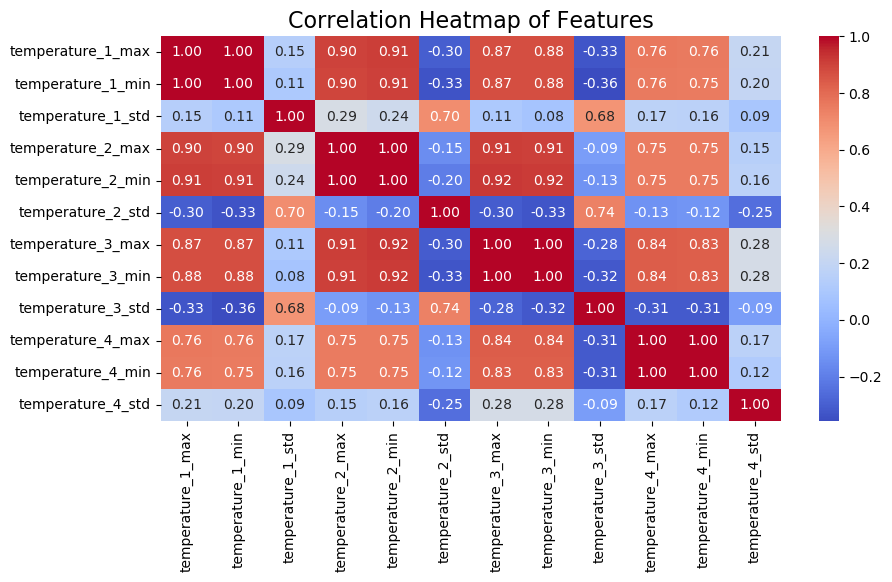

In [23]:
# Calculate correlation matrix
correlation_matrix = np.corrcoef(outlier_removed_features, rowvar=False)
correlation_df = pd.DataFrame(correlation_matrix, index=feature_column, columns=feature_column)

# Plot heatmap using Seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()

### Observation

The correlation values between the features remain relatively unchanged after removing outliers, with only a slight decrease observed. This suggests that the removal of outliers has not led to a significant improvement in the strength or clarity of the relationships between the features, at least in terms of correlation

In [24]:
pca = PCA(0.99)
outlier_removed_pca_features = pca.fit_transform(outlier_removed_features)

In [25]:
avg_acc = []
avg_f1score = []

folds = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in folds.split(outlier_removed_pca_features, outlier_removed_label):
    X_train, y_train = outlier_removed_pca_features[train_idx], outlier_removed_label[train_idx]
    X_test, y_test = outlier_removed_pca_features[test_idx], outlier_removed_label[test_idx]
    acc, f1score = fit_model(RandomForestClassifier(),
                              X_train, X_test, y_train, y_test,
                              smote = True)
    avg_acc.append(acc)
    avg_f1score.append(f1score)

print("The Random Forest Performance after 5-folds \n")
print(f"The average Accuracy is {sum(avg_acc)/len(avg_acc):.4f}")
print(f"The average f1-Score is {sum(avg_f1score)/len(avg_f1score):.4f}")

The Random Forest Performance after 5-folds 

The average Accuracy is 0.9855
The average f1-Score is 0.8766


### Observation

Removing outliers has had a positive impact on the Random Forest model's performance, both in terms of overall accuracy and, more notably, the F1-score. This suggests that the outliers were likely influencing the model's ability to generalize, especially in terms of handling the minority class.

## Hyperparameter Tunning

### GridSearch with cross validation

In [26]:
%%time

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'criterion' : ["gini", "entropy", "log_loss"], #The function to measure the quality of a split
    # 'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10, 20],  # Minimum number of samples required to split a node
    # 'min_samples_leaf': [1, 2, 5, 10],  # Minimum number of samples required to be at a leaf node
    # 'max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    # 'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'class_weight': ['balanced', None],  # Weighting of the classes
    'n_jobs': [-1],  # Use all available processors for training
    # 'oob_score': [True, False],  # Whether to use out-of-bag samples to estimate the generalization error
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(outlier_removed_pca_features, 
                                                    outlier_removed_label,
                                                    test_size=0.2,
                                                    shuffle=True
                                               )

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=5,  # 5-fold cross-validation
                           scoring='f1',  # Use F1-score for evaluation
                           verbose=3,  # Display progress
                           n_jobs=-1,  # Use all processors
                           return_train_score=True)

# Fit GridSearchCV to the data (replace `X_train` and `y_train` with your dataset)
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best F1-Score: ", grid_search.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters:  {'class_weight': None, 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 150, 'n_jobs': -1}
Best F1-Score:  0.9932094773404889
CPU times: total: 21.4 s
Wall time: 51min 36s


### Observation

All the default parameters turned out to be the best one, there is change in the n_estimators seems to be 150 trees is best compared to 100.

GridSearchCV helps to find the best parameters across all the criterion, due to limitage in time and processor have done limited than the possibilities.

In [29]:
rf = RandomForestClassifier(n_estimators=150)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
                              

The F1-Score after hyperparameter tuning is  0.8634976013955517


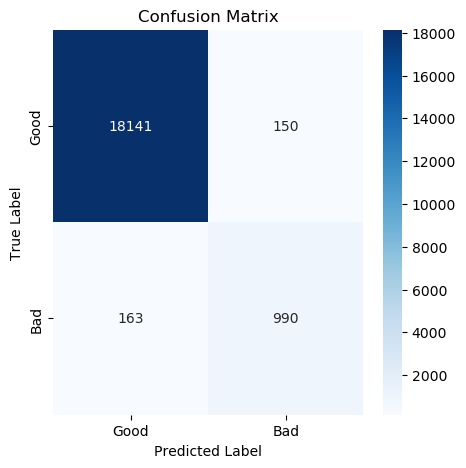

In [30]:
print("The F1-Score after hyperparameter tuning is ", f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
labels = ['Good', 'Bad']

# Plot
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Conclusion

There is potential to further reduce misclassifications (313 currently) by exploring more complex models like XGBoost or Deep Learning (Recurrent Neural Networks (RNNs) or Long Short-Term Memory (LSTM)). Additionally, tuning hyperparameters and experimenting with feature engineering might help improve performance.

### Advanced Models for Further Improvement:
**XGBoost (Extreme Gradient Boosting):** XGBoost is an efficient and powerful gradient-boosted trees model that could provide better performance.

**Deep Learning (Neural Networks):** The task involves time-series data with sequential and potentially complex patterns, Recurrent Neural Networks (RNNs) or Long Short-Term Memory (LSTM) networks could potentially capture temporal dependencies and improve the prediction accuracy. 

### Feature Engineering:
**Temporal Features:** As the data comes from temperature sensors over time, incorporating temporal features such as time-based rolling statistics (e.g., rolling means, rolling standard deviations) and time-related features like the elapsed time between parts.

**Statistical Features:** Skewness, Kurtosis

Could improve the performance and reduce misclassification (True negatives and False positives)